# 数值稳定性和模型初始化
初始化⽅案的选择在神经⽹络学习中起着举⾜轻重的作⽤，它对保持数值稳定性⾄关重要。糟糕选择可能会导致我们在训练时遇到梯度爆炸或梯度消失。

## 梯度消失和梯度爆炸
考虑⼀个具有L层、输⼊x和输出o的深层⽹络。每⼀层l由变换fl定义，该变换的参数为权重W(l)，其隐藏变量是h(l)（令 h(0) = x）。我们的⽹络可以表⽰为：  
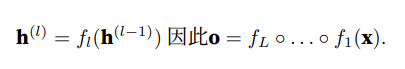  
如果所有隐藏变量和输⼊都是向量，我们可以将o关于任何⼀组参数W(l)的梯度写为下式：  
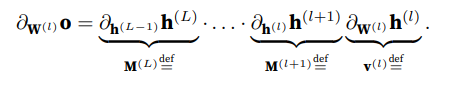  
换⾔之，该梯度是L − l个矩阵 M(L)· . . . · M(l+1) 与梯度向量 v(l)的乘积。因此，我们容易受到数值下溢问题的影响. 当将太多的概率乘在⼀起时，这些问题经常会出现。在处理概率时，⼀个常⻅的技巧是切换到对数空间，即将数值表⽰的压⼒从尾数转移到指数。不幸的是，上⾯的问题更为严重：最初，矩阵 M(l) 可能具有各种各样的特征值。他们可能很⼩，也可能很⼤；他们的乘积可能⾮常⼤，也可能⾮常⼩。  


不稳定梯度带来的⻛险不⽌在于数值表⽰；不稳定梯度也威胁到我们优化算法的稳定性。我们可能⾯临⼀些问题。要么是梯度爆炸（gradient exploding）问题：参数更新过⼤，破坏了模型的稳定收敛；要么是梯度消失（gradient vanishing）问题：参数更新过⼩，在每次更新时⼏乎不会移动，导致模型⽆法学习。




### 梯度消失
曾经sigmoid函数1/(1 + exp(−x))很流⾏，因为它类似于阈值函数。由于早期的⼈⼯神经⽹络受到⽣物神经⽹络的启发，神经元要么完全激活要么完全不激活（就像⽣物神经元）的想法很有吸引⼒。然⽽，它却是导致梯度消失问题的⼀个常⻅的原因，让我们仔细看看sigmoid函数为什么会导致梯度消失。

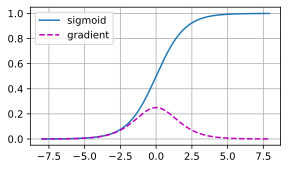

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

d2l.plot(x.detach().numpy(), [y.detach().numpy(), x.grad.numpy()],
        legend=['sigmoid', 'gradient'], figsize=(4.5, 2.5))

正如上图，当sigmoid函数的输⼊很⼤或是很⼩时，它的梯度都会消失。此外，当反向传播通过许多层时，除⾮我们在刚刚好的地⽅，这些地⽅sigmoid函数的输⼊接近于零，否则整个乘积的梯度可能会消失。当我们
的⽹络有很多层时，除⾮我们很⼩⼼，否则在某⼀层可能会切断梯度。事实上，这个问题曾经困扰着深度⽹络的训练。因此，更稳定的ReLU系列函数已经成为从业者的默认选择（虽然在神经科学的⻆度看起来不太合理）。

### 梯度爆炸
相反，梯度爆炸可能同样令⼈烦恼。为了更好地说明这⼀点，我们⽣成100个⾼斯随机矩阵，并将它们与某个初始矩阵相乘。对于我们选择的尺度（⽅差σ^2 = 1），矩阵乘积发⽣爆炸。当这种情况是由于深度⽹络的初始化所导致时，我们没有机会让梯度下降优化器收敛

In [2]:
M = torch.normal(0, 1, size=(4,4))
print('⼀个矩阵 \n',M)
for i in range(100):
    M = torch.mm(M,torch.normal(0, 1, size=(4, 4)))
print('乘以100个矩阵后\n', M)


⼀个矩阵 
 tensor([[-0.0482, -0.1024, -0.0182,  0.7528],
        [ 0.4575,  0.3959, -1.4157,  0.5453],
        [-0.8238, -0.2541,  1.1507, -2.3643],
        [-0.0365,  0.7853,  0.4278, -0.6080]])
乘以100个矩阵后
 tensor([[-6.9550e+22, -1.0350e+21,  1.1624e+22,  2.4583e+22],
        [-2.5707e+23, -3.8256e+21,  4.2964e+22,  9.0864e+22],
        [ 4.8874e+23,  7.2733e+21, -8.1682e+22, -1.7274e+23],
        [ 3.5074e+22,  5.2196e+20, -5.8619e+21, -1.2397e+22]])


### 打破对称性
神经⽹络设计中的另⼀个问题是其参数化所固有的对称性。假设我们有⼀个简单的多层感知机，它有⼀个隐
藏层和两个隐藏单元。在这种情况下，我们可以对第⼀层的权重W(1)进⾏重排列，并且同样对输出层的权重
进⾏重排列，可以获得相同的函数。第⼀个隐藏单元与第⼆个隐藏单元没有什么特别的区别。换句话说，我
们在每⼀层的隐藏单元之间具有排列对称性。  

假设输出层将上述两个隐藏单元的多层感知机转换为仅⼀个输出单元。想象⼀下，如果我们将隐藏层的所有
参数初始化为W(1) = c，c为常量，会发⽣什么？在这种情况下，在前向传播期间，两个隐藏单元采⽤相同
的输⼊和参数，产⽣相同的激活，该激活被送到输出单元。在反向传播期间，根据参数W(1)对输出单元进⾏
微分，得到⼀个梯度，其元素都取相同的值。因此，在基于梯度的迭代（例如，⼩批量随机梯度下降）之后，
W(1)的所有元素仍然采⽤相同的值。这样的迭代永远不会打破对称性，我们可能永远也⽆法实现⽹络的表达
能⼒。隐藏层的⾏为就好像只有⼀个单元。请注意，虽然⼩批量随机梯度下降不会打破这种对称性，但暂退
法正则化可以。


## 参数初始化
解决（或⾄少减轻）上述问题的⼀种⽅法是进⾏参数初始化，优化期间的注意和适当的正则化也可以进⼀步
提⾼稳定性。  

### 默认初始化
在前⾯的部分中，使⽤正态分布来初始化权重值。如果我们不指定初始化⽅法，框架将
使⽤默认的随机初始化⽅法，对于中等难度的问题，这种⽅法通常很有效。

### Xavier初始化
让我们看看某些没有⾮线性的全连接层输出（例如，隐藏变量）oi的尺度分布。对于该层nin输⼊xj及其相关
权重wij，输出由下式给出：  
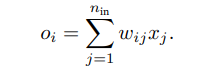  
权重wij都是从同⼀分布中独⽴抽取的。此外，让我们假设该分布具有零均值和⽅差σ2。请注意，这并不意味
着分布必须是⾼斯的，只是均值和⽅差需要存在。现在，让我们假设层xj的输⼊也具有零均值和⽅差γ2，并
且它们独⽴于wij并且彼此独⽴。在这种情况下，我们可以按如下⽅式计算oi的平均值和⽅差：  
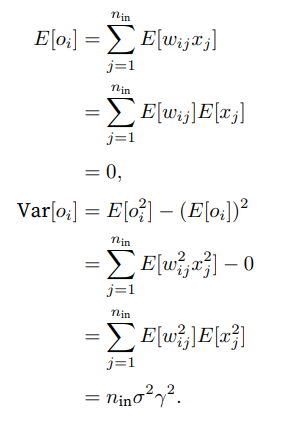  

保持⽅差不变的⼀种⽅法是设置ninσ2 = 1。现在考虑反向传播过程，我们⾯临着类似的问题，尽管梯度是从
更靠近输出的层传播的。使⽤与前向传播相同的推断，我们可以看到，除⾮noutσ2 = 1，否则梯度的⽅差可能
会增⼤，其中nout是该层的输出的数量。这使得我们进退两难：我们不可能同时满⾜这两个条件。相反，我们
只需满⾜：  
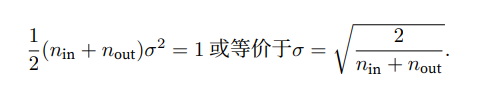  
这就是现在标准且实⽤的Xavier初始化的基础，通常，Xavier初始化从均值为零，⽅差 σ2 =2nin+nout 的⾼斯分布中采样权重。我们也可以将其改为选择
从均匀分布中抽取权重时的⽅差。注意均匀分布U(−a, a)的⽅差为a2/3 。将a2/3 代⼊到σ2的条件中，将得到初始化值域：  
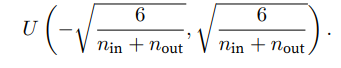  
尽管在上述数学推理中，“不存在⾮线性”的假设在神经⽹络中很容易被违反，但Xavier初始化⽅法在实践中
被证明是有效的。





## 额外阅读
上⾯的推理仅仅触及了现代参数初始化⽅法的⽪⽑。深度学习框架通常实现⼗⼏种不同的启发式⽅法。此外，
参数初始化⼀直是深度学习基础研究的热点领域。其中包括专⻔⽤于参数绑定（共享）、超分辨率、序列模型
和其他情况的启发式算法。

## 小结
* 梯度消失和梯度爆炸是深度⽹络中常⻅的问题。在参数初始化时需要⾮常⼩⼼，以确保梯度和参数可以得到很好的控制。
* 需要⽤启发式的初始化⽅法来确保初始梯度既不太⼤也不太⼩。
* ReLU激活函数缓解了梯度消失问题，这样可以加速收敛。
* 随机初始化是保证在进⾏优化前打破对称性的关键。
* Xavier初始化表明，对于每⼀层，输出的⽅差不受输⼊数量的影响，任何梯度的⽅差不受输出数量的影响。

